### Imports et Configuration Initiale

In [3]:

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt


### Préparation des Données

In [4]:

def prepare_iris_dataset():
    iris = load_iris()
    X = iris.data
    y = iris.target
    return X, y


### Extraction des Méta-Caractéristiques

In [5]:

def extract_meta_features_multi(X, y):
    meta_features = []
    for i in range(X.shape[1]):
        x_col = X[:, i]
        std_val = np.std(x_col)

        # Gestion des valeurs constantes
        if std_val == 0:
            skewness = 0
        else:
            skewness = np.mean(((x_col - np.mean(x_col)) / std_val)**3)

        meta_features.append({
            'Feature': f'X{i}',
            'mean': np.mean(x_col),
            'std': std_val,
            'range': np.max(x_col) - np.min(x_col),
            'skew': skewness,
            'class_separation': np.var([np.mean(x_col[y == c]) for c in np.unique(y)])
        })

    return pd.DataFrame(meta_features)


### Classe AdvancedMetaLearner

In [6]:

class AdvancedMetaLearner:
    def __init__(self, model_type='rf', n_features=4):
        self.model_type = model_type
        self.n_features = n_features
        self.scaler = StandardScaler()
        if model_type == 'rf':
            self.model = RandomForestClassifier(n_estimators=100, max_depth=10)
        elif model_type == 'svc':
            self.model = SVC(kernel='rbf', C=1.0, probability=True)

    def train(self, meta_features, optimal_params):
        meta_features = np.nan_to_num(meta_features)
        X_scaled = self.scaler.fit_transform(meta_features)
        self.model.fit(X_scaled, optimal_params)

    def predict(self, meta_features):
        meta_features = np.nan_to_num(meta_features)
        X_scaled = self.scaler.transform(meta_features.reshape(1, -1))
        return self.model.predict_proba(X_scaled)[0]


### Évaluation du Système de Méta-Apprentissage

In [7]:

def evaluate_meta_learning_system():
    X_full, y_full = prepare_iris_dataset()
    n_features = X_full.shape[1]

    meta_features = []
    optimal_params = []
    n_samples = len(X_full)
    subset_size = n_samples // 5  # Diviser en 5 sous-ensembles

    for i in range(0, n_samples, subset_size):
        X_subset = X_full[i:i+subset_size]
        y_subset = y_full[i:i+subset_size]

        meta = extract_meta_features_multi(X_subset, y_subset)
        meta_values = meta.iloc[:, 1:].values.flatten()

        if not np.any(np.isnan(meta_values)):
            meta_features.append(meta_values)
            optimal_params.append(np.argmax(np.bincount(y_subset)))

    meta_features = np.array(meta_features)
    optimal_params = np.array(optimal_params)

    X_train, X_val, y_train, y_val = train_test_split(meta_features, optimal_params, test_size=0.2, random_state=42)

    rf_meta_learner = AdvancedMetaLearner(model_type='rf', n_features=n_features)
    svc_meta_learner = AdvancedMetaLearner(model_type='svc', n_features=n_features)
    rf_meta_learner.train(X_train, y_train)
    svc_meta_learner.train(X_train, y_train)

    X_test, y_test = X_full[:30], y_full[:30]
    meta_dict = extract_meta_features_multi(X_test, y_test)
    test_meta_features = meta_dict.iloc[:, 1:].values.flatten()

    predictions_rf = rf_meta_learner.predict(test_meta_features)
    predictions_svc = svc_meta_learner.predict(test_meta_features)

    return X_test, y_test, predictions_rf, predictions_svc


### Classification avec Descente de Gradient (Softmax)

In [8]:

def train_softmax_classifier(X, y, W_init, epochs=500, learning_rate=0.01):
    W = W_init.copy()
    n_classes = len(np.unique(y))
    losses = []

    y_one_hot = np.eye(n_classes)[y]

    for i in range(epochs):
        scores = np.dot(X, W)
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        loss = -np.mean(np.sum(y_one_hot * np.log(probs + 1e-10), axis=1))
        losses.append(loss)

        dW = np.dot(X.T, (probs - y_one_hot)) / len(X)
        W = W - learning_rate * dW

    return W, losses


### Comparaison des Approches

=== Initialisations ===

Initialisation aléatoire :
Poids initiaux : [[ 0.01418828]
 [-0.00181292]
 [ 0.00406872]
 [ 0.00904753]]

Initialisation par Random Forest :
Poids initiaux : [[0.73 0.17 0.1 ]
 [0.73 0.17 0.1 ]
 [0.73 0.17 0.1 ]
 [0.73 0.17 0.1 ]]

Initialisation par SVC :
Poids initiaux : [[0.12052343 0.36188243 0.51759414]
 [0.12052343 0.36188243 0.51759414]
 [0.12052343 0.36188243 0.51759414]
 [0.12052343 0.36188243 0.51759414]]

=== Résultats après descente de gradient ===

Poids finaux avec initialisation aléatoire :
[[ 0.01418828]
 [-0.00181292]
 [ 0.00406872]
 [ 0.00904753]]

Poids finaux avec initialisation par Random Forest :
[[16.97378444 17.13628734 17.15659489]
 [11.87520514 11.81612279 11.80867207]
 [ 5.47730632  5.14862883  5.10739819]
 [ 1.52037475  1.0053873   0.94090462]]

Poids finaux avec initialisation par SVC :
[[17.15057487 17.08060054 17.03549126]
 [11.81081321 11.83641374 11.85277306]
 [ 5.11942571  5.26128526  5.35262236]
 [ 0.95977559  1.18190382  1.32

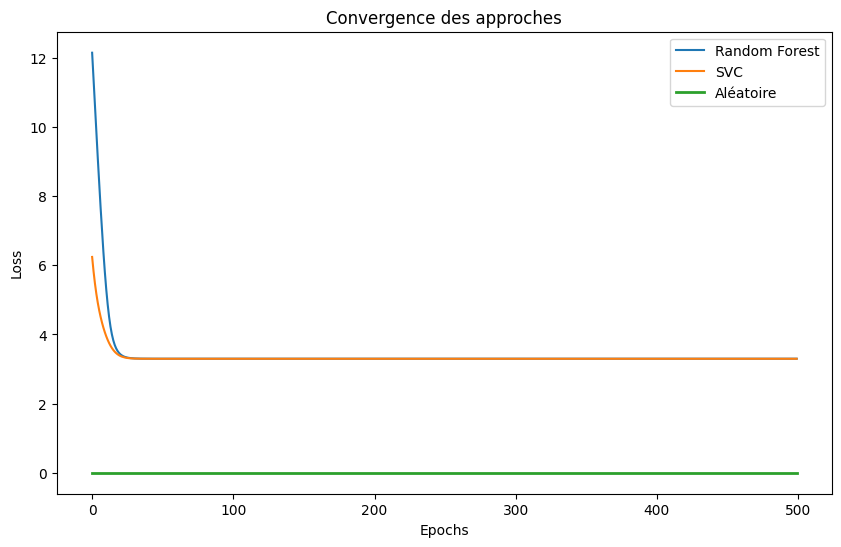

In [9]:
# Comparaison des approches
X_test, y_test, pred_rf, pred_svc = evaluate_meta_learning_system()

# Initialisation des poids
n_features = X_test.shape[1]
n_classes = len(np.unique(y_test))

# Initialisation des matrices de poids avec répétition des prédictions
W_rf = np.tile(pred_rf, (n_features, 1))  # Répète les prédictions pour chaque feature
W_svc = np.tile(pred_svc, (n_features, 1))  # Répète les prédictions pour chaque feature
W_random = np.random.randn(n_features, n_classes) * 0.01  # Petite initialisation aléatoire

print("=== Initialisations ===")
print("\nInitialisation aléatoire :")
print("Poids initiaux :", W_random)

print("\nInitialisation par Random Forest :")
print("Poids initiaux :", W_rf)

print("\nInitialisation par SVC :")
print("Poids initiaux :", W_svc)

# Entraînement avec descente de gradient
W_rf_final, losses_rf = train_softmax_classifier(X_test, y_test, W_rf)
W_svc_final, losses_svc = train_softmax_classifier(X_test, y_test, W_svc)
W_rand_final, losses_rand = train_softmax_classifier(X_test, y_test, W_random)

# Résultats finaux
print("\n=== Résultats après descente de gradient ===")
print("\nPoids finaux avec initialisation aléatoire :")
print(W_rand_final)

print("\nPoids finaux avec initialisation par Random Forest :")
print(W_rf_final)

print("\nPoids finaux avec initialisation par SVC :")
print(W_svc_final)

# Évaluation des performances finales
def evaluate_accuracy(X, y, W):
    scores = np.dot(X, W)
    predicted_classes = np.argmax(scores, axis=1)
    accuracy = np.mean(predicted_classes == y)
    return accuracy

print("\n=== Accuracy sur l'ensemble de test ===")
print(f"Accuracy avec initialisation aléatoire: {evaluate_accuracy(X_test, y_test, W_rand_final):.4f}")
print(f"Accuracy avec initialisation RF: {evaluate_accuracy(X_test, y_test, W_rf_final):.4f}")
print(f"Accuracy avec initialisation SVC: {evaluate_accuracy(X_test, y_test, W_svc_final):.4f}")

# Courbes de convergence
plt.figure(figsize=(10, 6))
plt.plot(losses_rf, label="Random Forest")
plt.plot(losses_svc, label="SVC")
plt.plot(losses_rand, label="Aléatoire", linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Convergence des approches")
plt.show()